In [1]:
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pmdarima as pm
from typing import List
import warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
KPI_data = {os.path.splitext(os.path.basename(file_name))[0] : pd.read_csv(file_name) for file_name in glob.glob('original_data/*')}   

child_mortality_df = KPI_data["child_mortality_0_5_year_olds_dying_per_1000_born"]
coal_consumption_df = KPI_data["coal_consumption_per_cap"]
food_supply_df = KPI_data["food_supply_kilocalories_per_person_and_day"]
med_beds_df = KPI_data["sh_med_beds_zs"]

countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Functions

In [3]:
def plot_global_map(df:pd.DataFrame, year:int, continents: List[str] = list(set(countries.continent)), ax=None):
    year = "{}".format(year)
    title = get_dataframe_name(df) + " " + year
    df = countries[countries['continent'].isin(continents)].set_index('name').join(df.set_index('country'))
    plot_global_map_figure(df=df, year=year, title=title, ax=ax)
    
def plot_global_map_figure(df: pd.DataFrame, year: str, title: str, ax):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 6))
    
    df.plot(column=year, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title)
    if ax is None:
        vmin = df[year].min()
        vmax = df[year].max()
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        plt.tight_layout()
        plt.colorbar(sm)

def plot_global_map_subplot(df_list: List[pd.DataFrame], year: int, continents: List[str] = list(set(countries.continent))):
    n_plots = len(df_list)
    fig, axes = plt.subplots(nrows=n_plots, ncols=1, figsize=(n_plots*5, 20))
    
    for i, df in enumerate(df_list):
        plot_global_map(df=df, year=year, ax=axes[i])
    
    plt.tight_layout()
    plt.show()
    
def get_dataframe_name(df: pd.DataFrame):
    for name, obj in globals().items():
        if obj is df:
            return name

# Collective data analysis

In [4]:
for dataset_name in KPI_data:
    print(dataset_name, "\t\033[1m" + KPI_data[dataset_name].columns[-1] + "\033[0m") 

child_mortality_0_5_year_olds_dying_per_1000_born 	2100
coal_consumption_per_cap 	2019
food_supply_kilocalories_per_person_and_day 	2018
sh_med_beds_zs 	2019
underweight_children 	2008


### Intersection of countries name in KPI_data

In [5]:
dataset_country_name = [set(KPI_data[_].country) for _ in KPI_data]
print(dataset_country_name[0].intersection(*dataset_country_name[1:]))

{'Azerbaijan', 'Netherlands', 'North Macedonia', 'Chile', 'India', 'China', 'Saudi Arabia', 'Sri Lanka', 'Germany', 'Ukraine', 'Trinidad and Tobago', 'Argentina', 'Philippines', 'Kazakhstan', 'Brazil', 'Egypt', 'Belarus', 'Morocco', 'Indonesia', 'Bulgaria', 'Mexico', 'Algeria', 'Turkey', 'Colombia', 'Iraq', 'United States', 'Vietnam', 'Ecuador', 'Thailand', 'Czech Republic', 'Peru', 'Uzbekistan', 'Romania', 'Hungary', 'Bangladesh', 'Pakistan', 'Oman'}


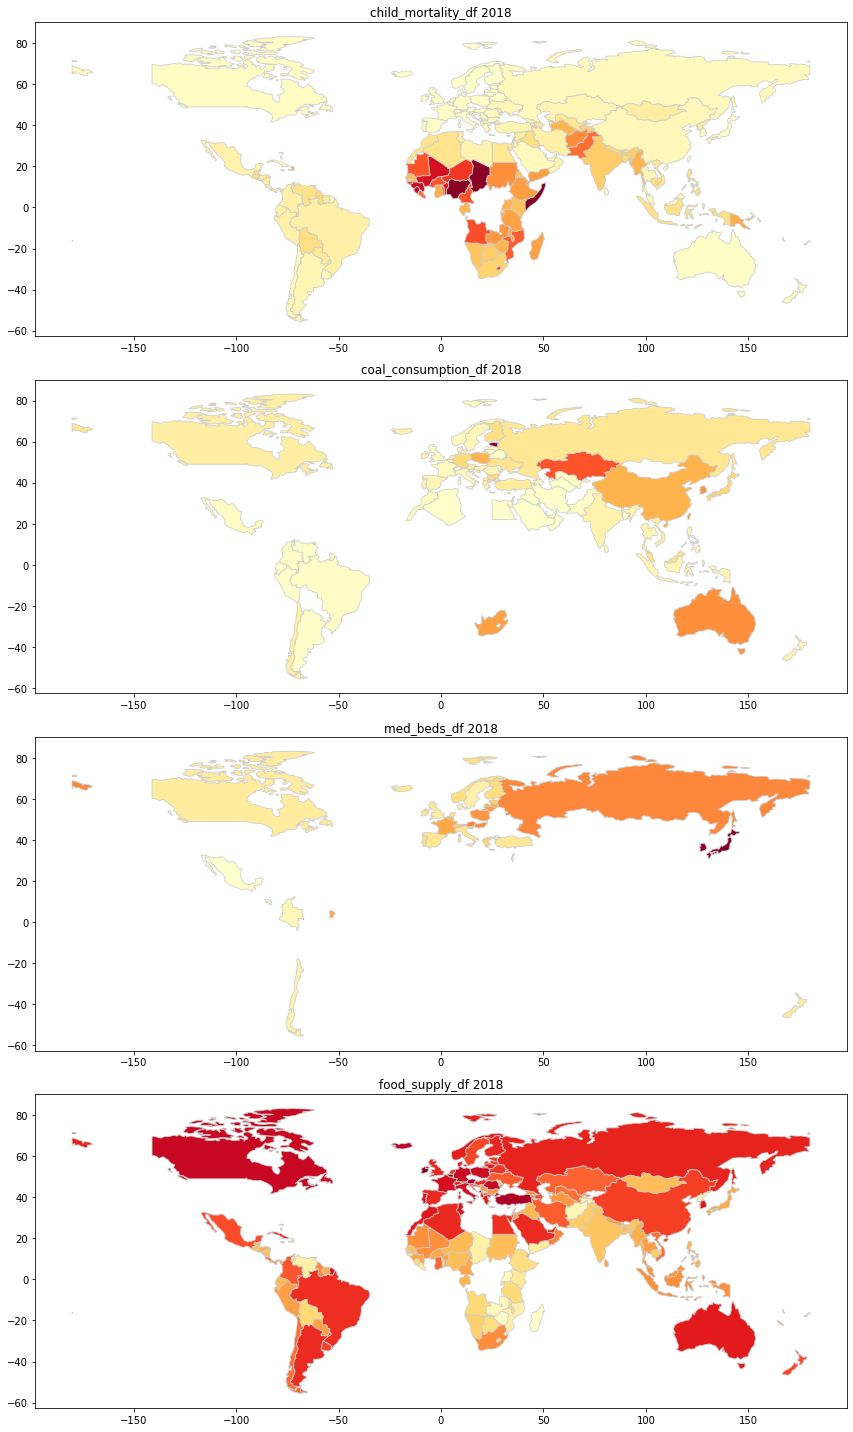

In [6]:
plot_global_map_subplot(df_list=[child_mortality_df, coal_consumption_df, med_beds_df, food_supply_df], year=2018)

# Data Imputation

In [7]:
years_range = [str(i) for i in range(2000, 2020)]

### child_mortality_0_5_year_olds_dying_per_1000_born

In [8]:
child_mortality_df.columns

Index(['country', '1800', '1801', '1802', '1803', '1804', '1805', '1806',
       '1807', '1808',
       ...
       '2091', '2092', '2093', '2094', '2095', '2096', '2097', '2098', '2099',
       '2100'],
      dtype='object', length=302)

In [9]:
child_mortality_df = child_mortality_df[["country"] + years_range]
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,...,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70,62.30,60.10
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,...,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40,77.20,74.50
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,...,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02,8.82,8.68
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,...,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01,2.89,2.87
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,...,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68,7.59,7.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,21.10,20.40,19.90,19.50,19.20,19.00,18.90,18.90,18.90,...,18.70,18.50,18.30,17.90,17.60,17.20,16.70,16.30,15.80,15.40
193,Yemen,94.90,90.30,85.60,81.10,76.70,72.50,68.40,64.60,61.00,...,56.00,55.10,55.00,55.00,55.00,55.00,55.00,55.00,55.00,54.90
194,South Africa,73.90,75.80,77.40,79.10,79.40,78.50,76.00,71.00,64.80,...,52.50,46.70,43.30,41.20,39.50,37.70,36.60,35.30,33.80,32.90
195,Zambia,162.00,153.00,142.00,130.00,119.00,110.00,101.00,95.40,90.40,...,80.30,77.20,74.30,70.70,66.90,64.60,62.00,59.40,57.80,56.10


In [10]:
child_mortality_df[child_mortality_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019


In [11]:
child_mortality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  197 non-null    object 
 1   2000     197 non-null    float64
 2   2001     197 non-null    float64
 3   2002     197 non-null    float64
 4   2003     197 non-null    float64
 5   2004     197 non-null    float64
 6   2005     197 non-null    float64
 7   2006     197 non-null    float64
 8   2007     197 non-null    float64
 9   2008     197 non-null    float64
 10  2009     197 non-null    float64
 11  2010     197 non-null    float64
 12  2011     197 non-null    float64
 13  2012     197 non-null    float64
 14  2013     197 non-null    float64
 15  2014     197 non-null    float64
 16  2015     197 non-null    float64
 17  2016     197 non-null    float64
 18  2017     197 non-null    float64
 19  2018     197 non-null    float64
 20  2019     197 non-null    float64
dtypes: float64(20), 

### coal_consumption_per_cap

In [12]:
coal_consumption_df.columns

Index(['country', '1965', '1966', '1967', '1968', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019'],
      dtype='object')

In [13]:
coal_consumption_df = coal_consumption_df[["country"] + years_range]
coal_consumption_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,United Arab Emirates,0,0.0056,0.02710,0.0299,0.0309,0.03170,0.05310,0.02200,0.04840,...,0.07700,0.04970,0.15100,0.19200,0.21400,0.18500,0.19700,0.22400,0.25000,0.25200
1,Argentina,0.0175,0.0142,0.01050,0.0126,0.0213,0.02420,0.02170,0.03110,0.03760,...,0.02830,0.03040,0.02820,0.03040,0.03210,0.03160,0.02410,0.02450,0.02660,0.01220
2,Australia,2.68,2.62,2.65000,2.7,2.78,2.72000,2.75000,2.67000,2.73000,...,2.36000,2.26000,2.08000,1.95000,1.90000,1.94000,1.91000,1.82000,1.77000,1.69000
3,Austria,0.453,0.466,0.47100,0.5,0.487,0.48400,0.48200,0.46400,0.45700,...,0.40100,0.41000,0.37900,0.38300,0.34800,0.37400,0.34400,0.35300,0.32100,0.33600
4,Azerbaijan,0,0.00037,0.00024,0.00036,0.00011,0.00038,0.00037,0.00057,0.00042,...,0.00061,0.00054,0.00040,0.00033,0.00019,0.00032,0.00013,0.00013,0.00012,0.00012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,United States,1.92,1.84,1.83000,1.84,1.84,1.85000,1.80000,1.81000,1.77000,...,1.61000,1.51000,1.32000,1.36000,1.35000,1.16000,1.05000,1.02000,0.97000,0.82300
75,Uzbekistan,0.0286,0.0307,0.03080,0.0213,0.0293,0.03220,0.03280,0.03390,0.03670,...,0.03590,0.03770,0.03950,0.05420,0.05080,0.04510,0.04150,0.04810,0.06250,0.05260
76,Venezuela,0.00546,0.00198,0.00073,0.00169,0,0.00141,0.00922,0.00509,0.00510,...,0.00701,0.00710,0.00719,0.00706,0.00656,0.00454,0.00413,0.00432,0.00398,0.00265
77,Vietnam,0.0587,0.0635,0.07180,0.0828,0.107,0.11200,0.06770,0.07340,0.13800,...,0.16500,0.19500,0.17900,0.18900,0.22700,0.28300,0.30300,0.30000,0.39700,0.51300


In [14]:
coal_consumption_df[coal_consumption_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019


In [15]:
coal_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  79 non-null     object 
 1   2000     79 non-null     object 
 2   2001     79 non-null     object 
 3   2002     79 non-null     float64
 4   2003     79 non-null     object 
 5   2004     79 non-null     object 
 6   2005     79 non-null     float64
 7   2006     79 non-null     float64
 8   2007     79 non-null     float64
 9   2008     79 non-null     float64
 10  2009     79 non-null     float64
 11  2010     79 non-null     float64
 12  2011     79 non-null     float64
 13  2012     79 non-null     float64
 14  2013     79 non-null     float64
 15  2014     79 non-null     float64
 16  2015     79 non-null     float64
 17  2016     79 non-null     float64
 18  2017     79 non-null     float64
 19  2018     79 non-null     float64
 20  2019     79 non-null     float64
dtypes: float64(16), ob

In [16]:
for i in range(1, 10):
    coal_consumption_df = coal_consumption_df.replace(str(i) + '0µ', str(i * 10**-5))

In [17]:
for year in [2000, 2001, 2003, 2004]:
    coal_consumption_df[str(year)] = coal_consumption_df[str(year)].astype("float64")

In [18]:
coal_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  79 non-null     object 
 1   2000     79 non-null     float64
 2   2001     79 non-null     float64
 3   2002     79 non-null     float64
 4   2003     79 non-null     float64
 5   2004     79 non-null     float64
 6   2005     79 non-null     float64
 7   2006     79 non-null     float64
 8   2007     79 non-null     float64
 9   2008     79 non-null     float64
 10  2009     79 non-null     float64
 11  2010     79 non-null     float64
 12  2011     79 non-null     float64
 13  2012     79 non-null     float64
 14  2013     79 non-null     float64
 15  2014     79 non-null     float64
 16  2015     79 non-null     float64
 17  2016     79 non-null     float64
 18  2017     79 non-null     float64
 19  2018     79 non-null     float64
 20  2019     79 non-null     float64
dtypes: float64(20), ob

### food_supply_kilocalories_per_person_and_day

In [19]:
food_supply_df.columns

Index(['country', '1961', '1962', '1963', '1964', '1965', '1966', '1967',
       '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976',
       '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985',
       '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017', '2018'],
      dtype='object')

In [20]:
food_supply_df = food_supply_df[["country"] + years_range[:-1]]
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,2080.0,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,2300.0,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,2990.0,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0
3,Netherlands Antilles,3080.0,3050.0,3070.0,3060.0,3080.0,3090.0,3090.0,3070.0,3080.0,3100.0,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,3170.0,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,2160.0,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0
175,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,2940.0,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,1880.0,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0


In [21]:
food_supply_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  179 non-null    object 
 1   2000     174 non-null    float64
 2   2001     174 non-null    float64
 3   2002     174 non-null    float64
 4   2003     174 non-null    float64
 5   2004     174 non-null    float64
 6   2005     174 non-null    float64
 7   2006     175 non-null    float64
 8   2007     175 non-null    float64
 9   2008     175 non-null    float64
 10  2009     175 non-null    float64
 11  2010     175 non-null    float64
 12  2011     174 non-null    float64
 13  2012     174 non-null    float64
 14  2013     174 non-null    float64
 15  2014     172 non-null    float64
 16  2015     172 non-null    float64
 17  2016     172 non-null    float64
 18  2017     172 non-null    float64
 19  2018     172 non-null    float64
dtypes: float64(19), object(1)
memory usage: 28.1+ KB


In [22]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
3,Netherlands Antilles,3080.0,3050.0,3070.0,3060.0,3080.0,3090.0,3090.0,3070.0,3080.0,3100.0,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Bermuda,2650.0,2610.0,2580.0,2490.0,2460.0,2520.0,2590.0,2630.0,2700.0,2720.0,2680.0,2650.0,2650.0,2670.0,NaN,NaN,NaN,NaN,NaN
24,Brunei,2800.0,2880.0,2930.0,2980.0,3000.0,2980.0,2970.0,2920.0,2910.0,2890.0,2890.0,2940.0,2970.0,2990.0,NaN,NaN,NaN,NaN,NaN
29,Czechoslovakia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,Montenegro,NaN,NaN,NaN,NaN,NaN,NaN,3280.0,3410.0,3480.0,3490.0,3460.0,3480.0,3370.0,3490.0,3380.0,3420.0,3480.0,3500.0,3500.0
139,Serbia and Montenegro,2650.0,2610.0,2630.0,2700.0,2700.0,2700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,Serbia,NaN,NaN,NaN,NaN,NaN,NaN,2750.0,2710.0,2720.0,2760.0,2730.0,2730.0,2720.0,2730.0,2810.0,2790.0,2810.0,2820.0,2830.0
167,USSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### If there are gaps in values, they are not isolated

In [23]:
food_supply_df = food_supply_df.dropna()

In [24]:
food_supply_df[food_supply_df.isna().any(axis=1)]

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018


In [25]:
food_supply_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 178
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  170 non-null    object 
 1   2000     170 non-null    float64
 2   2001     170 non-null    float64
 3   2002     170 non-null    float64
 4   2003     170 non-null    float64
 5   2004     170 non-null    float64
 6   2005     170 non-null    float64
 7   2006     170 non-null    float64
 8   2007     170 non-null    float64
 9   2008     170 non-null    float64
 10  2009     170 non-null    float64
 11  2010     170 non-null    float64
 12  2011     170 non-null    float64
 13  2012     170 non-null    float64
 14  2013     170 non-null    float64
 15  2014     170 non-null    float64
 16  2015     170 non-null    float64
 17  2016     170 non-null    float64
 18  2017     170 non-null    float64
 19  2018     170 non-null    float64
dtypes: float64(19), object(1)
memory usage: 27.9+ KB


In [26]:
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,2080.0,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,2300.0,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,2990.0,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,3170.0,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,3130.0,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,2770.0,2820.0,2820.0,2830.0,2880.0,2890.0,2860.0,2850.0,2910.0,2880.0,2910.0,2880.0,2960.0,2960.0,2970.0,2970.0,3000.0,3040.0,3030.0
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,2160.0,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,2940.0,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,1880.0,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0


In [27]:
df = food_supply_df.drop(["country"], axis = 1)


In [28]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=1))
    pred.append(prediction)

In [29]:
for i in range(len(pred)):
    pred[i] = float(int(pred[i].iat[0, 0]))

In [30]:
food_supply_df["2019"] = pred
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,...,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,...,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0,2423.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,...,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0,3395.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,...,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0,3285.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,...,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,2770.0,2820.0,2820.0,2830.0,2880.0,2890.0,2860.0,2850.0,2910.0,...,2910.0,2880.0,2960.0,2960.0,2970.0,2970.0,3000.0,3040.0,3030.0,3055.0
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,...,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0,2142.0
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,...,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0,2892.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,...,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0,2000.0


### sh_med_beds_zs

In [31]:
med_beds_df.columns

Index(['country', '1960', '1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

In [32]:
med_beds_df = med_beds_df [["country"] + years_range]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39,NaN,NaN
1,Angola,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,...,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,3.20,2.59,NaN,3.30,NaN,2.70,2.60,2.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Samoa,3.30,NaN,1.50,2.04,NaN,1.00,NaN,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Yemen,0.59,0.59,0.59,0.59,0.59,0.61,0.70,0.70,0.70,...,0.72,0.70,0.72,0.67,0.71,0.71,0.71,0.71,NaN,NaN
198,South Africa,NaN,NaN,3.10,NaN,2.87,2.80,NaN,2.41,2.39,...,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,Zambia,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.90,...,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
med_beds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  201 non-null    object 
 1   2000     99 non-null     float64
 2   2001     103 non-null    float64
 3   2002     113 non-null    float64
 4   2003     108 non-null    float64
 5   2004     109 non-null    float64
 6   2005     133 non-null    float64
 7   2006     134 non-null    float64
 8   2007     119 non-null    float64
 9   2008     114 non-null    float64
 10  2009     127 non-null    float64
 11  2010     139 non-null    float64
 12  2011     134 non-null    float64
 13  2012     118 non-null    float64
 14  2013     112 non-null    float64
 15  2014     112 non-null    float64
 16  2015     107 non-null    float64
 17  2016     104 non-null    float64
 18  2017     98 non-null     float64
 19  2018     36 non-null     float64
 20  2019     8 non-null      float64
dtypes: float64(20), 

In [34]:
med_beds_df = med_beds_df [["country"] + years_range[:-2]]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39
1,Angola,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,3.01,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN
3,Andorra,3.20,2.59,NaN,3.30,NaN,2.70,2.60,2.60,NaN,2.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Samoa,3.30,NaN,1.50,2.04,NaN,1.00,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Yemen,0.59,0.59,0.59,0.59,0.59,0.61,0.70,0.70,0.70,0.70,0.72,0.70,0.72,0.67,0.71,0.71,0.71,0.71
198,South Africa,NaN,NaN,3.10,NaN,2.87,2.80,NaN,2.41,2.39,NaN,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,Zambia,NaN,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.90,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
med_beds_df = med_beds_df[med_beds_df.isna().sum(axis=1) < 9]
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.30,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.50,0.50,0.50,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,NaN,3.01,2.99,2.88,2.88,2.89,NaN,NaN,NaN,NaN
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.10,1.36,1.38
5,Argentina,4.10,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,NaN,4.50,4.39,4.59,4.78,4.84,4.96,4.95,4.99
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,3.72,3.73,3.74,4.05,4.06,4.16,4.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.20,3.18,3.14,3.13,3.08,3.05,2.97,2.93,2.89,2.83,2.80,2.77,2.87
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,4.58,4.44,4.32,4.19,3.99,3.98,NaN,NaN,NaN
191,St. Vincent and the Grenadines,NaN,4.70,4.50,4.50,4.50,4.50,NaN,3.00,NaN,NaN,2.60,2.52,2.41,2.41,2.40,4.33,4.32,NaN
194,Vietnam,2.34,2.40,1.40,NaN,2.80,2.34,2.66,NaN,2.90,3.10,2.91,NaN,2.50,3.18,2.60,NaN,NaN,NaN


In [36]:
med_beds_df = med_beds_df.T
med_beds_df

,0,2,4,5,6,7,8,9,10,12,...,181,182,183,187,188,189,190,191,194,197
country,Afghanistan,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,Azerbaijan,Belgium,...,Trinidad and Tobago,Tunisia,Turkey,Ukraine,Uruguay,United States,Uzbekistan,St. Vincent and the Grenadines,Vietnam,Yemen
2000,0.3,3.26,2.38,4.1,6.44,NaN,4.04,7.95,8.69,6.72,...,3.3,1.73,2.1,8.82,NaN,3.49,5.33,NaN,2.34,0.59
2001,0.39,3.26,2.28,NaN,5.03,2.6,3.95,7.85,8.51,6.62,...,3.4,1.73,2.16,8.79,NaN,3.47,5.34,4.7,2.4,0.59
2002,0.39,3.14,2.19,NaN,4.35,2.3,3.93,7.81,8.4,6.54,...,NaN,1.71,2.49,8.89,NaN,3.39,5.54,4.5,1.4,0.59
2003,0.39,3.07,2.19,NaN,4.42,2.5,3.97,7.73,8.27,6.53,...,3.3,1.71,2.48,8.81,1.9,3.33,5.48,4.5,NaN,0.59
2004,0.39,3.01,2.19,NaN,4.44,2.4,4.0,7.73,8.24,6.48,...,NaN,2.05,2.47,8.73,NaN,3.26,5.26,4.5,2.8,0.59
2005,0.42,3.08,2.19,4.0,4.46,2.4,3.9,7.69,8.21,6.44,...,2.6,1.76,2.5,8.68,2.4,3.2,5.19,4.5,2.34,0.61
2006,0.42,3.12,1.88,NaN,4.42,2.4,3.93,7.66,7.94,6.35,...,2.7,1.98,2.52,8.73,2.9,3.18,5.12,NaN,2.66,0.7
2007,0.42,3.09,1.88,NaN,4.07,2.0,NaN,7.75,7.93,6.27,...,2.7,1.76,2.54,8.72,2.9,3.14,4.83,3.0,NaN,0.7
2008,0.42,NaN,1.86,NaN,3.82,1.7,3.82,7.69,7.67,6.25,...,2.5,2.0,2.58,8.75,NaN,3.13,4.67,NaN,2.9,0.7


In [37]:
med_beds_df = med_beds_df.fillna(method='bfill')
med_beds_df = med_beds_df.fillna(method='ffill')

In [38]:
med_beds_df = med_beds_df.T
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,0.42,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,3.01,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,1.93,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,4.5,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,3.72,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,3.08,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,4.58,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,2.6,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,3.1,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6


In [39]:
df = med_beds_df.drop(["country"], axis = 1)

In [40]:
pred = []
for _, row in df.iterrows():
    auto_arima=pm.auto_arima(row, start_p = 0, start_q = 0, max_p = 12, max_q = 12, m = 12, start_P = 0, start_Q = 0, seasonal = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    prediction = pd.DataFrame(auto_arima.predict(n_periods=2))
    pred.append(prediction)

In [41]:
pred_2018 = []
pred_2019 = []
for i in range(len(pred)):
    pred_2018.append(round(pred[i].iat[0, 0], 2))
    pred_2019.append(round(pred[i].iat[1, 0], 2))

In [42]:
med_beds_df["2018"] = pred_2018
med_beds_df["2019"] = pred_2019
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39,0.39,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,...,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89,2.87,2.85
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38,1.38,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,...,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99,5.04,5.09
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,...,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2,4.25,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,...,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87,2.83,2.80
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,...,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98,3.92,3.84
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,...,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32,4.23,4.15
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,...,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6,2.62,2.62


# Summary

In [43]:
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,129.00,125.00,121.00,117.00,113.00,109.00,104.00,100.00,96.00,...,88.00,84.10,80.50,77.00,73.50,70.40,67.50,64.70,62.30,60.10
1,Angola,206.00,200.00,193.00,185.00,176.00,167.00,157.00,148.00,138.00,...,120.00,113.00,105.00,98.40,92.90,88.10,84.00,80.40,77.20,74.50
2,Albania,25.90,24.50,23.10,21.80,20.40,19.20,17.90,16.70,15.50,...,13.30,12.30,11.40,10.70,10.10,9.60,9.27,9.02,8.82,8.68
3,Andorra,6.41,6.16,5.93,5.71,5.49,5.27,5.05,4.84,4.62,...,4.18,3.98,3.79,3.61,3.43,3.27,3.14,3.01,2.89,2.87
4,United Arab Emirates,11.20,10.90,10.60,10.30,10.00,9.73,9.44,9.18,8.93,...,8.48,8.28,8.13,8.00,7.91,7.83,7.76,7.68,7.59,7.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,21.10,20.40,19.90,19.50,19.20,19.00,18.90,18.90,18.90,...,18.70,18.50,18.30,17.90,17.60,17.20,16.70,16.30,15.80,15.40
193,Yemen,94.90,90.30,85.60,81.10,76.70,72.50,68.40,64.60,61.00,...,56.00,55.10,55.00,55.00,55.00,55.00,55.00,55.00,55.00,54.90
194,South Africa,73.90,75.80,77.40,79.10,79.40,78.50,76.00,71.00,64.80,...,52.50,46.70,43.30,41.20,39.50,37.70,36.60,35.30,33.80,32.90
195,Zambia,162.00,153.00,142.00,130.00,119.00,110.00,101.00,95.40,90.40,...,80.30,77.20,74.30,70.70,66.90,64.60,62.00,59.40,57.80,56.10


In [44]:
coal_consumption_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,United Arab Emirates,0.00000,0.00560,0.02710,0.02990,0.03090,0.03170,0.05310,0.02200,0.04840,...,0.07700,0.04970,0.15100,0.19200,0.21400,0.18500,0.19700,0.22400,0.25000,0.25200
1,Argentina,0.01750,0.01420,0.01050,0.01260,0.02130,0.02420,0.02170,0.03110,0.03760,...,0.02830,0.03040,0.02820,0.03040,0.03210,0.03160,0.02410,0.02450,0.02660,0.01220
2,Australia,2.68000,2.62000,2.65000,2.70000,2.78000,2.72000,2.75000,2.67000,2.73000,...,2.36000,2.26000,2.08000,1.95000,1.90000,1.94000,1.91000,1.82000,1.77000,1.69000
3,Austria,0.45300,0.46600,0.47100,0.50000,0.48700,0.48400,0.48200,0.46400,0.45700,...,0.40100,0.41000,0.37900,0.38300,0.34800,0.37400,0.34400,0.35300,0.32100,0.33600
4,Azerbaijan,0.00000,0.00037,0.00024,0.00036,0.00011,0.00038,0.00037,0.00057,0.00042,...,0.00061,0.00054,0.00040,0.00033,0.00019,0.00032,0.00013,0.00013,0.00012,0.00012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,United States,1.92000,1.84000,1.83000,1.84000,1.84000,1.85000,1.80000,1.81000,1.77000,...,1.61000,1.51000,1.32000,1.36000,1.35000,1.16000,1.05000,1.02000,0.97000,0.82300
75,Uzbekistan,0.02860,0.03070,0.03080,0.02130,0.02930,0.03220,0.03280,0.03390,0.03670,...,0.03590,0.03770,0.03950,0.05420,0.05080,0.04510,0.04150,0.04810,0.06250,0.05260
76,Venezuela,0.00546,0.00198,0.00073,0.00169,0.00000,0.00141,0.00922,0.00509,0.00510,...,0.00701,0.00710,0.00719,0.00706,0.00656,0.00454,0.00413,0.00432,0.00398,0.00265
77,Vietnam,0.05870,0.06350,0.07180,0.08280,0.10700,0.11200,0.06770,0.07340,0.13800,...,0.16500,0.19500,0.17900,0.18900,0.22700,0.28300,0.30300,0.30000,0.39700,0.51300


In [45]:
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,1790.0,1740.0,1830.0,1890.0,1970.0,1950.0,1970.0,2050.0,2040.0,...,2100.0,2110.0,2100.0,2090.0,2100.0,2040.0,2030.0,2050.0,2040.0,2040.0
1,Angola,1790.0,1830.0,1920.0,1980.0,2030.0,2080.0,2120.0,2170.0,2250.0,...,2350.0,2410.0,2380.0,2470.0,2420.0,2380.0,2340.0,2370.0,2390.0,2423.0
2,Albania,2730.0,2800.0,2860.0,2770.0,2790.0,2870.0,2860.0,2860.0,2950.0,...,3080.0,3130.0,3180.0,3190.0,3270.0,3280.0,3380.0,3390.0,3360.0,3395.0
4,United Arab Emirates,3300.0,3320.0,3360.0,3340.0,3290.0,3210.0,3200.0,3190.0,3150.0,...,3160.0,3210.0,3230.0,3280.0,3400.0,3410.0,3370.0,3340.0,3310.0,3285.0
5,Argentina,3260.0,3210.0,2980.0,3010.0,3030.0,3110.0,3110.0,3150.0,3160.0,...,3160.0,3160.0,3200.0,3230.0,3250.0,3310.0,3250.0,3270.0,3310.0,3310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,2770.0,2820.0,2820.0,2830.0,2880.0,2890.0,2860.0,2850.0,2910.0,...,2910.0,2880.0,2960.0,2960.0,2970.0,2970.0,3000.0,3040.0,3030.0,3055.0
174,Yemen,2090.0,2070.0,2080.0,2070.0,2070.0,2090.0,2120.0,2160.0,2130.0,...,2200.0,2210.0,2230.0,2220.0,2160.0,2170.0,2010.0,2070.0,2150.0,2142.0
176,South Africa,2890.0,2910.0,2910.0,2930.0,2940.0,2950.0,2930.0,2920.0,2920.0,...,2990.0,3000.0,3010.0,3020.0,2980.0,2940.0,2920.0,2940.0,2900.0,2892.0
177,Zambia,1870.0,1850.0,1850.0,1900.0,1870.0,1870.0,1840.0,1780.0,1800.0,...,1900.0,1910.0,1920.0,1930.0,2010.0,2030.0,1990.0,1990.0,2000.0,2000.0


In [46]:
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.3,0.39,0.39,0.39,0.39,0.42,0.42,0.42,0.42,...,0.43,0.44,0.53,0.53,0.5,0.5,0.5,0.39,0.39,0.39
2,Albania,3.26,3.26,3.14,3.07,3.01,3.08,3.12,3.09,3.01,...,2.99,2.88,2.88,2.89,2.89,2.89,2.89,2.89,2.87,2.85
4,United Arab Emirates,2.38,2.28,2.19,2.19,2.19,2.19,1.88,1.88,1.86,...,1.93,1.07,1.07,1.15,0.01,1.1,1.36,1.38,1.38,1.38
5,Argentina,4.1,4.0,4.0,4.0,4.0,4.0,4.5,4.5,4.5,...,4.5,4.39,4.59,4.78,4.84,4.96,4.95,4.99,5.04,5.09
6,Armenia,6.44,5.03,4.35,4.42,4.44,4.46,4.42,4.07,3.82,...,3.73,3.74,4.05,4.06,4.16,4.2,4.2,4.2,4.25,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,3.49,3.47,3.39,3.33,3.26,3.2,3.18,3.14,3.13,...,3.05,2.97,2.93,2.89,2.83,2.8,2.77,2.87,2.83,2.80
190,Uzbekistan,5.33,5.34,5.54,5.48,5.26,5.19,5.12,4.83,4.67,...,4.44,4.32,4.19,3.99,3.98,3.98,3.98,3.98,3.92,3.84
191,St. Vincent and the Grenadines,4.7,4.7,4.5,4.5,4.5,4.5,3.0,3.0,2.6,...,2.6,2.52,2.41,2.41,2.4,4.33,4.32,4.32,4.23,4.15
194,Vietnam,2.34,2.4,1.4,2.8,2.8,2.34,2.66,2.9,2.9,...,2.91,2.5,2.5,3.18,2.6,2.6,2.6,2.6,2.62,2.62


# World map vizualization

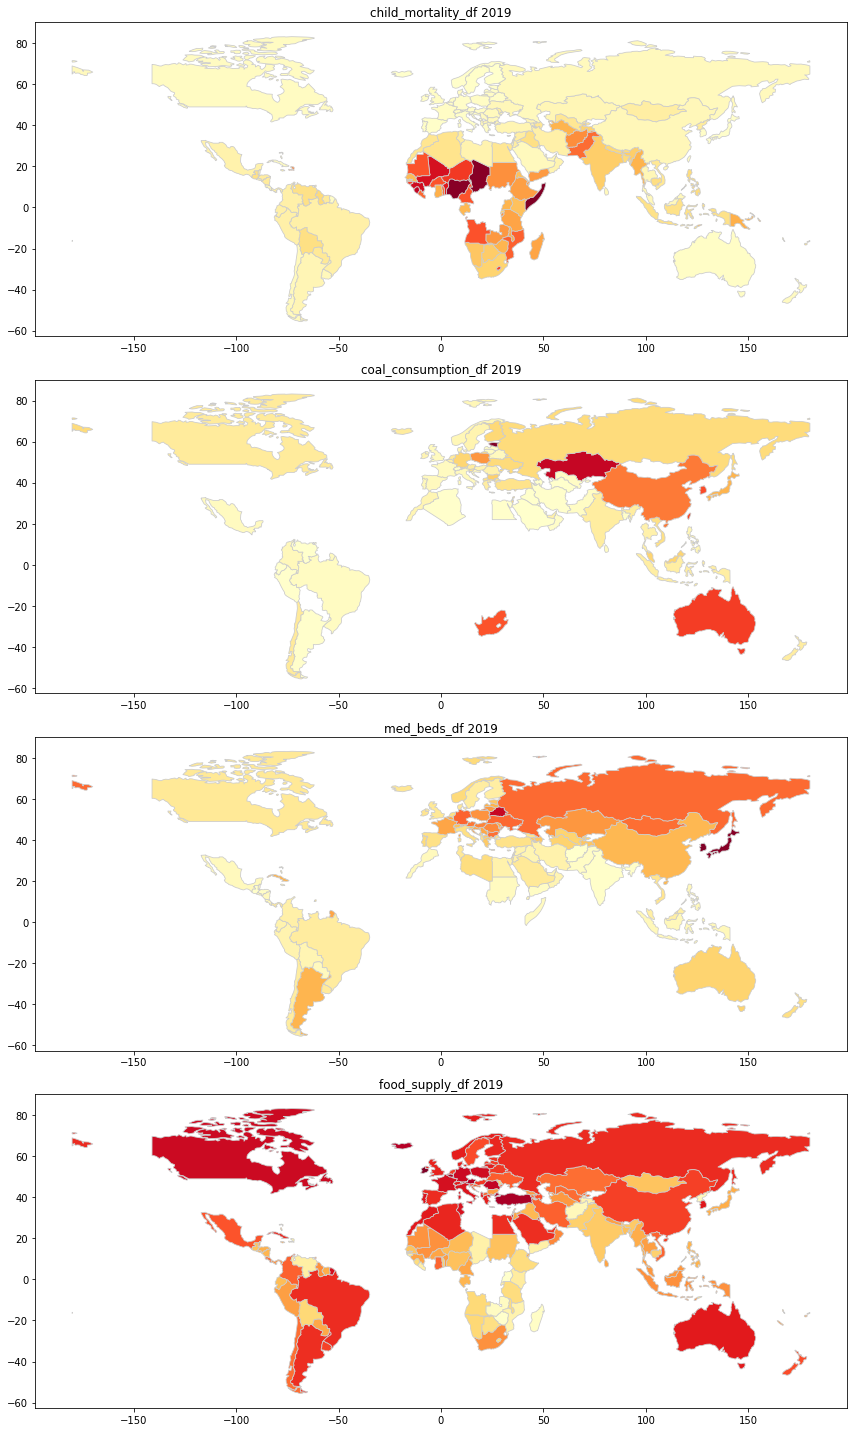

In [47]:
plot_global_map_subplot(df_list=[child_mortality_df, coal_consumption_df, med_beds_df, food_supply_df], year=2019)

# Data normalization

In [48]:
def normalize(df: pd.DataFrame):
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [49]:
normalize(child_mortality_df)
child_mortality_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.543756,0.538598,0.535561,0.532273,0.531265,0.527457,0.523588,0.521865,0.525879,...,0.413703,0.538553,0.540015,0.534584,0.524827,0.521480,0.515672,0.510353,0.503741,0.498168
1,Angola,0.878335,0.871340,0.863400,0.850327,0.835701,0.815957,0.798043,0.779736,0.762940,...,0.568757,0.729337,0.709483,0.687813,0.667747,0.656780,0.645613,0.637840,0.627598,0.620857
2,Albania,0.095768,0.092724,0.089791,0.086997,0.083792,0.080780,0.077728,0.074353,0.071513,...,0.051749,0.064563,0.062046,0.059860,0.057757,0.056719,0.057096,0.058222,0.059185,0.060066
3,Andorra,0.011080,0.011358,0.011611,0.011740,0.011743,0.011490,0.011185,0.010637,0.010103,...,0.007559,0.009638,0.009407,0.009094,0.008619,0.008332,0.008820,0.009419,0.009892,0.010565
4,United Arab Emirates,0.031894,0.032387,0.032875,0.033209,0.033536,0.033675,0.033918,0.033953,0.034430,...,0.028394,0.038025,0.039427,0.040527,0.041624,0.043189,0.045204,0.047341,0.048961,0.048905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Samoa,0.074911,0.074534,0.075221,0.076239,0.077994,0.079785,0.082906,0.086172,0.090704,...,0.077915,0.105492,0.109774,0.111413,0.113010,0.114814,0.115609,0.117337,0.117207,0.117321
193,Yemen,0.395585,0.384650,0.374374,0.364359,0.355852,0.345901,0.339237,0.331686,0.328329,...,0.258649,0.347109,0.363630,0.377059,0.388537,0.403761,0.417231,0.431587,0.443059,0.453864
194,South Africa,0.304336,0.320319,0.337037,0.355005,0.368899,0.375746,0.378593,0.366069,0.349777,...,0.241690,0.291656,0.282700,0.278247,0.274348,0.271518,0.272326,0.271620,0.266833,0.266422
195,Zambia,0.687147,0.662822,0.631181,0.593078,0.560259,0.532431,0.508052,0.497153,0.494271,...,0.376393,0.493002,0.497129,0.489474,0.476205,0.477144,0.472358,0.467316,0.466334,0.464088


In [50]:
normalize(coal_consumption_df)
coal_consumption_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,United Arab Emirates,0.000000,0.002137,0.010226,0.011074,0.011115,0.011654,0.019309,0.008240,0.017729,...,0.026280,0.015828,0.051186,0.060377,0.066667,0.063574,0.067235,0.069350,0.069444,0.099213
1,Argentina,0.006530,0.005420,0.003962,0.004667,0.007662,0.008897,0.007891,0.011648,0.013773,...,0.009659,0.009682,0.009559,0.009560,0.010000,0.010859,0.008225,0.007585,0.007389,0.004803
2,Australia,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.805461,0.719745,0.705085,0.613208,0.591900,0.666667,0.651877,0.563467,0.491667,0.665354
3,Austria,0.169030,0.177863,0.177736,0.185185,0.175180,0.177941,0.175273,0.173783,0.167399,...,0.136860,0.130573,0.128475,0.120440,0.108411,0.128522,0.117406,0.109288,0.089167,0.132283
4,Azerbaijan,0.000000,0.000141,0.000091,0.000133,0.000040,0.000140,0.000135,0.000213,0.000154,...,0.000208,0.000172,0.000136,0.000104,0.000059,0.000110,0.000044,0.000040,0.000033,0.000047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,United States,0.716418,0.702290,0.690566,0.681481,0.661871,0.680147,0.654545,0.677903,0.648352,...,0.549488,0.480892,0.447458,0.427673,0.420561,0.398625,0.358362,0.315789,0.269444,0.324016
75,Uzbekistan,0.010672,0.011718,0.011623,0.007889,0.010540,0.011838,0.011927,0.012697,0.013443,...,0.012253,0.012006,0.013390,0.017044,0.015826,0.015498,0.014164,0.014892,0.017361,0.020709
76,Venezuela,0.002037,0.000756,0.000275,0.000626,0.000000,0.000518,0.003353,0.001906,0.001868,...,0.002392,0.002261,0.002437,0.002220,0.002044,0.001560,0.001410,0.001337,0.001106,0.001043
77,Vietnam,0.021903,0.024237,0.027094,0.030667,0.038489,0.041176,0.024618,0.027491,0.050549,...,0.056314,0.062102,0.060678,0.059434,0.070717,0.097251,0.103413,0.092879,0.110278,0.201969


In [51]:
normalize(food_supply_df)
food_supply_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.000000,0.000000,0.000000,0.010471,0.051546,0.040816,0.067010,0.136364,0.125000,...,0.109890,0.109290,0.098901,0.111111,0.163366,0.149758,0.138614,0.122549,0.119048,0.109405
1,Angola,0.000000,0.044776,0.046154,0.057592,0.082474,0.107143,0.144330,0.196970,0.234375,...,0.247253,0.273224,0.252747,0.312169,0.321782,0.314010,0.292079,0.279412,0.285714,0.293186
2,Albania,0.477157,0.527363,0.528205,0.471204,0.474227,0.510204,0.525773,0.545455,0.598958,...,0.648352,0.666667,0.692308,0.693122,0.742574,0.748792,0.806931,0.779412,0.747619,0.759597
4,United Arab Emirates,0.766497,0.786070,0.784615,0.769634,0.731959,0.683673,0.701031,0.712121,0.703125,...,0.692308,0.710383,0.719780,0.740741,0.806931,0.811594,0.801980,0.754902,0.723810,0.706814
5,Argentina,0.746193,0.731343,0.589744,0.596859,0.597938,0.632653,0.654639,0.691919,0.708333,...,0.692308,0.683060,0.703297,0.714286,0.732673,0.763285,0.742574,0.720588,0.723810,0.718810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Samoa,0.497462,0.537313,0.507692,0.502618,0.520619,0.520408,0.525773,0.540404,0.578125,...,0.554945,0.530055,0.571429,0.571429,0.594059,0.599034,0.618812,0.607843,0.590476,0.596449
174,Yemen,0.152284,0.164179,0.128205,0.104712,0.103093,0.112245,0.144330,0.191919,0.171875,...,0.164835,0.163934,0.170330,0.179894,0.193069,0.212560,0.128713,0.132353,0.171429,0.158349
176,South Africa,0.558376,0.582090,0.553846,0.554974,0.551546,0.551020,0.561856,0.575758,0.583333,...,0.598901,0.595628,0.598901,0.603175,0.599010,0.584541,0.579208,0.558824,0.528571,0.518234
177,Zambia,0.040609,0.054726,0.010256,0.015707,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.026455,0.118812,0.144928,0.118812,0.093137,0.100000,0.090211


In [52]:
normalize(med_beds_df)
med_beds_df

,country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.00073,0.0,0.000741,0.000752,...,0.0,0.0,0.003123,0.003123,0.037149,0.0,0.018692,0.0,0.000000,0.000000
2,Albania,0.205556,0.20197,0.196288,0.192667,0.189718,0.195033,0.198822,0.198666,0.195636,...,0.195868,0.188272,0.186573,0.187354,0.218347,0.188189,0.204829,0.196696,0.196047,0.192037
4,United Arab Emirates,0.144444,0.133005,0.12848,0.129403,0.13034,0.130022,0.107511,0.10897,0.109105,...,0.114767,0.048611,0.045277,0.051522,0.0,0.047244,0.08567,0.077891,0.078261,0.077283
5,Argentina,0.263889,0.254046,0.257673,0.259526,0.261405,0.262235,0.300442,0.303188,0.30775,...,0.3114,0.304784,0.320062,0.334895,0.366187,0.351181,0.365265,0.36192,0.367589,0.366901
6,Armenia,0.426389,0.326531,0.282655,0.28972,0.293266,0.295836,0.294551,0.271312,0.256584,...,0.252487,0.25463,0.277908,0.278689,0.314632,0.291339,0.306854,0.299764,0.305138,0.309133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,United States,0.221528,0.216749,0.214133,0.211359,0.20782,0.203798,0.20324,0.202372,0.204665,...,0.200459,0.195216,0.190476,0.187354,0.213798,0.181102,0.195483,0.195122,0.192885,0.188134
190,Uzbekistan,0.349306,0.348346,0.367595,0.365924,0.352643,0.34916,0.346097,0.32765,0.320542,...,0.306809,0.299383,0.288837,0.273224,0.300986,0.274016,0.28972,0.282455,0.279051,0.269321
191,St. Vincent and the Grenadines,0.305556,0.303308,0.293362,0.295471,0.29761,0.298758,0.189985,0.191994,0.164786,...,0.166029,0.160494,0.149883,0.149883,0.181198,0.301575,0.316199,0.309205,0.303557,0.293521
194,Vietnam,0.141667,0.14145,0.072091,0.173257,0.174511,0.140979,0.164948,0.184581,0.187359,...,0.189748,0.158951,0.156909,0.209992,0.196361,0.165354,0.182243,0.173879,0.176285,0.174083


# Data correlation analysis

In [53]:
dataframes = {
    'child_mortality': child_mortality_df,
    'coal_consumption': coal_consumption_df,
    'food_supply': food_supply_df,
    'med_beds': med_beds_df
}

for name, df in dataframes.items():
    df.rename(columns={'2019': name}, inplace=True)
merged_df = child_mortality_df[['country']].copy()

for name, df in dataframes.items():
    merged_df = merged_df.merge(df[['country', name]], on='country')


In [54]:
correlations = merged_df.iloc[:, 1:].corrwith(merged_df['child_mortality'])
print(correlations)

child_mortality     1.000000
coal_consumption   -0.242490
food_supply        -0.595379
med_beds           -0.387329
dtype: float64


In [57]:
country_corr = pd.DataFrame()
country_corr['country'] = merged_df['country']
country_corr['2019'] = merged_df.iloc[:, 1:].apply(lambda row: sum(abs(row - row.mean())), axis=1)

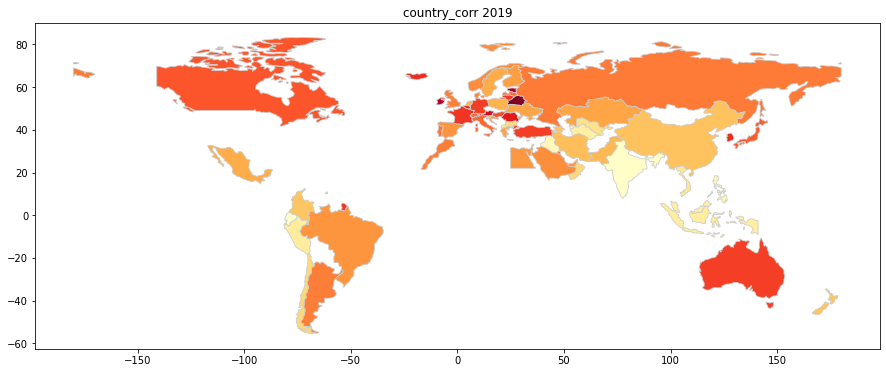

In [58]:
plot_global_map(df=country_corr, year=2019)

In [60]:
merged_df.to_csv('./analysis_data/analysis_data.csv')